# Similarity between genres of books

### Importing of Libraries and Reading of Data

In [1]:
import re
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import repeat
from sklearn.feature_extraction import stop_words
from collections import Counter
from operator import itemgetter


pd.set_option('display.max_colwidth', -1)

In [2]:
df= pd.read_csv('okadabooks_main.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 9 columns):
Unnamed: 0    14803 non-null int64
Title         14803 non-null object
Author        14803 non-null object
Genre         14803 non-null object
Price         14803 non-null int64
Reads         14803 non-null int64
Ratings       14803 non-null float64
Booklink      14803 non-null object
Blurb         14802 non-null object
dtypes: float64(1), int64(3), object(5)
memory usage: 1.0+ MB


In [4]:
df=df.dropna()
df= df.drop(columns= 'Unnamed: 0')

### Dropping duplicated Blurbs

**<u>Definition of Blurb: </u>**  
A blurb is a short description of a book, film, or other product written for promotional purposes.

Dropping blurb duplicates to increase accuracy of result. An example of what can cause a duplicated blurb is when an author publishes a preview of a novel and the novel itself (both at different Prices) with the same Blurb. All duplicates are in the same category with the original.

**N/B: In this notebook, THE words "category" and "genre" of books will be used interchangeably.**

In [6]:
df= df.drop_duplicates(subset=['Blurb'], keep= 'first')

In [7]:
len(df)

14395

### Normalizing the blurb 

Normalizing of the blurb column by getting rid of special characters and changing all letters to lower cases. All functions will be done on the norm_blurb column

In [8]:
df['norm_blurb']= df.Blurb
df.norm_blurb= df.norm_blurb.astype(str)

In [9]:
## change all capital letters to small letters
df.norm_blurb= df.norm_blurb.apply(lambda x: x.lower())
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.replace('\r\r\r\r\n', ' '))
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.replace('.', ' '))
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.replace('  ', ' '))
df['norm_blurb'] = df.norm_blurb.map(lambda x: re.sub(r'[^\w]', ' ', x)) ##takes care of anything not alpha numeric like symbols ❤️ [14783]
df['norm_blurb'] = df.norm_blurb.map(lambda x: x.translate(str.maketrans('', '', string.digits)))

In [10]:
df

,Title,Author,Genre,Price,Reads,Ratings,Booklink,Blurb,norm_blurb
0,the long walk,Milton J Davis,science_fiction,360,0,0.00,https://okadabooks.com/book/about/the_long_walk/29737,"Patience de Verteuil left her home in Trinidad with her father for what she thought would be a short journey to America. Instead she finds herself embroiled in a struggle between powerful supernatural forces, in which an object in her possession means the difference between defeat or victory. The Long Walk is a Steamfunk tale that will stay with you long after the final words are read.",patience de verteuil left her home in trinidad with her father for what she thought would be a short journey to america instead she finds herself embroiled in a struggle between powerful supernatural forces in which an object in her possession means the difference between defeat or victory the long walk is a steamfunk tale that will stay with you long after the final words are read
1,bilisi: rebirth of the orisha #1.,Tomi Adegbite.,science_fiction,1500,0,0.00,https://okadabooks.com/book/about/bilisi_rebirth_of_the_orisha_1/29663,"Enter a world or two of pure fantasy and wonder, as Bilisi Soneye discovers herself in more than one reality.",enter a world or two of pure fantasy and wonder as bilisi soneye discovers herself in more than one reality
2,woman of the woods,Milton J Davis,science_fiction,1440,0,0.00,https://okadabooks.com/book/about/woman_of_the_woods/29664,"Sadatina, an Adamu girl on the brink of becoming a woman has lived a peaceful life with her family in Adamusola, the land beyond the Old Men Mountains. But tragic events change her life forever, revealing a hidden past that leads her into the midst of a war between her people and those that would see them destroyed, the Mosele. Armed with a spiritual weapon and her feline 'sisters,' Sadatina becomes a Shosa, a warrior trained to fight the terrible nyokas, demon-like creatures that aid the Mosele in their war against her people. Woman of the Woods by Milton Davis is an action filled, emotionally charged adventure that expands the scope of the world of Uhuru and introduces another unforgettable character to the fabled continent's heroic legends.",sadatina an adamu girl on the brink of becoming a woman has lived a peaceful life with her family in adamusola the land beyond the old men mountains but tragic events change her life forever revealing a hidden past that leads her into the midst of a war between her people and those that would see them destroyed the mosele armed with a spiritual weapon and her feline sisters sadatina becomes a shosa a warrior trained to fight the terrible nyokas demonlike creatures that aid the mosele in their war against her people woman of the woods by milton davis is an action filled emotionally charged adventure that expands the scope of the world of uhuru and introduces another unforgettable character to the fabled continents heroic legends
3,priestess of nku,Milton J Davis,science_fiction,1440,0,0.00,https://okadabooks.com/book/about/priestess_of_nku/29626,"When the Bindamu invaded her homeland, First Hunter Nandi of the Chuiku (Leopard Clan) was chosen by her people and her Priestess to lead the fight against them. But does she possess the skills and strength to unite the rival nKu against the powerful empire?",when the bindamu invaded her homeland first hunter nandi of the chuiku leopard clan was chosen by her people and her priestess to lead the fight against them but does she possess the skills and strength to unite the rival nku against the powerful empire
4,the adventures of the book of truth,Joseph Emmanuel,science_fiction,200,2,0.00,https://okadabooks.com/book/about/the_adventures_of_the_book_of_truth/29563,Magic ruled the world of men and those without magic fought to survive the powers of magic demonstrated by the Duriach. The fate of those without magic lays on the son of the high god who has to use the power of the book of truth to defeat the Duriach and bring freedo

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14395 entries, 0 to 14802
Data columns (total 9 columns):
Title         14395 non-null object
Author        14395 non-null object
Genre         14395 non-null object
Price         14395 non-null int64
Reads         14395 non-null int64
Ratings       14395 non-null float64
Booklink      14395 non-null object
Blurb         14395 non-null object
norm_blurb    14395 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [12]:
print('The total number of words in the norm_blurb column is ', sum(df.norm_blurb.map(lambda x: len(x.split())))/ 1000000," Million")

The total number of words in the norm_blurb column is  1.119537  Million


There are 1M+ words left after special characters, punctuation and numbers have been removed from the normalized blurb column. The words will then be used to check similarity metrics between genres. 

## Selection of the genres to be used

In okadabooks.com where the data used for this analysis was scraped, There are 22 categories whcih are called genre here. A quick look that the no of rows and columns throughout the dataframe will help to choose genres with more words which will in turn help increase the accuracy of this analysis. 
I am choosing four categories/genres here.

In [13]:
print(df.Genre.unique()) ###View all the categories of books in okadabokks.com

['science_fiction' 'business_finance' 'religion_and_beliefs' 'self_help'
 'mystery' 'educational' 'memoir' 'fiction' 'non-fiction' 'health_living'
 'other' 'children' 'romance' 'adventure' 'free' 'raw_unpublished_works'
 'comics' 'history' 'drama' 'poetry' 'humor' 'erotic']


In [14]:
def print_list():
    dash= "-"*100
    print(dash)
    print('{:<1s}{:>40s}{:>50s}'.format("Category"," #Books","#Total Words in all Blurbs"))
    print (dash)
    for i in df.Genre.unique():
        no_rows= len(df[df.Genre==i])
        no_words= sum(df[df.Genre==i].norm_blurb.map(lambda x: len(x.split())))
        print('{:<20s}{:^50d}{:>20d}'.format(i, no_rows,no_words))
        

In [15]:
print_list()

----------------------------------------------------------------------------------------------------
Category                                  #Books                        #Total Words in all Blurbs
----------------------------------------------------------------------------------------------------
science_fiction                            307                                       18758
business_finance                           570                                       66651
religion_and_beliefs                       1299                                     159460
self_help                                  1194                                     143485
mystery                                    500                                       35135
educational                                728                                       67557
memoir                                     131                                       13189
fiction                                    1727               

From a quick look at the number of words across the genres, You can notice some have more words compared to the others. I decided to go with genres that have a better probability of giving a better/more accurate result. I choose genres with a least a 100,000 of words in their Blurbs. Romance, self_help, religion_and_beliefs, fiction and a data frame containing 2000 random rows from the four of them will be used. I am going to create seperate tables for them. 

In [16]:
romance_df= df[df.Genre=="romance"]
selfhelp_df= df[df.Genre=="self_help"]
religion_df= df[df.Genre=="religion_and_beliefs"]
fiction_df= df[df.Genre=="fiction"]
random_df =  df[ (df.Genre== 'romance') | (df.Genre=="self_help") | (df.Genre=="religion_and_beliefs") | (df.Genre=="fiction")]

In [17]:
##Data frame containing 2000 random rows from either romance_df, selfhelp_df, religion_df or fiction_df
random_df = random_df.sample(2000)
len(random_df)

2000

In [18]:
random_df.head(2)

,Title,Author,Genre,Price,Reads,Ratings,Booklink,Blurb,norm_blurb
4999,bride of an empire (free),Sarah Olaoye,fiction,0,28,0.0,https://okadabooks.com/book/about/bride_of_an_empire_free/28978,"Aliyah Badmus was too angry with God to believe in Him, she couldn’t serve a God that had watched while her father and brother died in a ghastly motor accident that left her mother limbless. Forced to care for her disabled mother she struggled to make ends meet until she met Laura, a Christian friend that told her God still loves her. She gave God a condition that the only way she would serve Him is if He could return everything He took from her.\r\r\r\r\n\r\r\r\r\nFate brought her into contact with Otunba Funsho Philips and he made her an offer she could not refuse. Does Aliyah have what it takes to be the bride of an Empire? Can she save FUMA and its heir? When she discovered that the odds were against her she ran to God but will He still accept and save her?\r\r\r\r\n\r\r\r\r\nLinda Thompson is not about to let the heir of FUMA escape her grasp because she spent all her youth grooming him, can Aliyah defeat this formidable enemy?\r\r\r\r\n\r\r\r\r\nAs one scandal after another rock FUMA Aliyah is determined to reveal the true heir of the Empire. She knows her strength will fail her, and she doesn’t have enough wisdom to deal with her skilled and cunning enemies so she set out to find that door that even the devil cannot break. \r\r\r\r\n\r\r\r\r\nIf you are looking for a good Christian Thriller with enough suspense to keep your attention, enough romance to keep you interested without being sexually explicit, enough crime to keep you hooked, and enough scriptural insight to inspire you; then Bride of an Empire is the book you are looking for.\r\r\r\r\n",aliyah badmus was too angry with god to believe in him she couldn t serve a god that had watched while her father and brother died in a ghastly motor accident that left her mother limbless forced to care for her disabled mother she struggled to make ends meet until she met laura a christian friend that told her god still loves her she gave god a condition that the only way she would serve him is if he could return everything he took from her fate brought her into contact with otunba funsho philips and he made her an offer she could not refuse does aliyah have what it takes to be the bride of an empire can she save fuma and its heir when she discovered that the odds were against her she ran to god but will he still accept and save her linda thompson is not about to let the heir of fuma escape her grasp because she spent all her youth grooming him can aliyah defeat this formidable enemy as one scandal after another rock fuma aliyah is determined to reveal the true heir of the empire she knows her strength will fail her and she doesn t have enough wisdom to deal with her skilled and cunning enemies so she set out to find that door that even the devil cannot break if you are looking for a good christian thriller with enough suspense to keep your attention enough romance to keep you interested without being sexually explicit enough crime to keep you hooked and enough scriptural insight to inspire you then bride of an empire is the book you are looking for
2441,the practical career playbook,Omono Okonkwo,self_help,700,0,5.0,https://okadabooks.com/book/about/the_practical_career_playbook/26977,"This eBook is specifically written for African professionals who need to know the steps needed to advance their chosen careers. \r\r\r\r\n\r\r\r\r\nIt will show the readers how to properly position themselves to become gainfully employed.\r\r\r\r\n\r\r\r\r\nThe book also contains easy steps to writing great CVs, Cover Letters, and LinkedIn profiles, which are all important in landing great jobs!",this ebook is specifically written for african professionals who need to know the steps needed to advance their chosen careers it will show the readers how to properly position themselves to become gainfully emp

## Eliminating stop words and creating a dictionary 

Stop words are the most common words in a language. In the English language, some examples of stop words are the, are, but, and they. Most sentences need to contain stop words in order to be full sentences that make sense. There are words that have no/little influence in semantic relationship. They include regular english expressions. 

Generally, stop words are removed because they aren’t significant and distort the word frequency analysis. In this analysis, all stop words will be removed.

In [19]:
print('Number of words in stopwords list:', len(stop_words.ENGLISH_STOP_WORDS))
print()
print('50 words on the stopwords list:', list(stop_words.ENGLISH_STOP_WORDS)[:50])

Number of words in stopwords list: 318

50 words on the stopwords list: ['whether', 'moreover', 'everything', 'been', 'ltd', 'go', 'everywhere', 'whole', 'elsewhere', 'somehow', 'show', 'meanwhile', 'cant', 'everyone', 'whereafter', 'herself', 'throughout', 'might', 'almost', 'somewhere', 'ie', 'enough', 'then', 'eight', 'when', 'be', 'two', 'off', 'ours', 'any', 'it', 'whither', 'whose', 'thin', 'yourselves', 'ten', 'amongst', 'three', 'was', 'twenty', 'into', 'nowhere', 'other', 'thus', 'whereas', 'out', 'whereupon', 'get', 'first', 'under']


In [20]:
def create_dict(norm_blurb):
    norm_blurb.astype(str)
    wordlist = [blurb.split(' ') for blurb in norm_blurb] # Create a list of lists (words in each review).
    wordlist = [word for blurb in wordlist for word in blurb] # Flatten the wordlist to create one list of all words in the reviews.
    vocab_dict = Counter(wordlist) # Create a Counter object (a dictionary of words and their frequencies).    
    for word in list(vocab_dict):
        if word in stop_words.ENGLISH_STOP_WORDS or word=='':
            del vocab_dict[word]
    return vocab_dict    


In [21]:
all_dict= create_dict(df.norm_blurb)
romance_dict= create_dict(romance_df.norm_blurb)
selfhelp_dict= create_dict(selfhelp_df.norm_blurb)
religion_dict= create_dict(religion_df.norm_blurb)
fiction_dict = create_dict(fiction_df.norm_blurb)
random_dict= create_dict (random_df.norm_blurb)

In [22]:
sum(df.norm_blurb.map(lambda x: len(x.split())))

1119537

In [23]:
print('Number of unique words in all genres:' , len(all_dict))
print('Number of unique words in all romance novels: ', len(romance_dict))
print('Number of unique words in all self help books: ', len(selfhelp_dict))
print('Number of unique words in all religious books: ', len(religion_dict))
print('Number of unique words in all fiction novels: ', len(fiction_dict))
print('Number of unique words in all random: ', len(random_dict))

Number of unique words in all genres: 51275
Number of unique words in all romance novels:  11828
Number of unique words in all self help books:  10880
Number of unique words in all religious books:  12104
Number of unique words in all fiction novels:  19282
Number of unique words in all random:  19260


In [24]:
print('Most commmon words in all genres:' , all_dict.most_common(10), '\n' ) 
print('Most commmon words in all romance novels: ', romance_dict.most_common(10), '\n')
print('Most commmon words in all self help books: ', selfhelp_dict.most_common(10), '\n')
print('Most commmon words in all religious books: ', religion_dict.most_common(10), '\n')
print('Most commmon words in all fiction novels: ', fiction_dict.most_common(10), '\n')
print('Most commmon words in all random: ', random_dict.most_common(10), '\n')

Most commmon words in all genres: [('book', 5923), ('life', 5290), ('da', 3294), ('s', 3030), ('love', 2955), ('god', 2718), ('story', 2467), ('people', 2172), ('time', 1967), ('ya', 1946)] 

Most commmon words in all romance novels:  [('love', 960), ('life', 416), ('s', 404), ('story', 289), ('da', 282), ('book', 248), ('man', 223), ('romance', 220), ('ta', 201), ('just', 176)] 

Most commmon words in all self help books:  [('book', 1349), ('life', 1240), ('time', 507), ('people', 426), ('make', 391), ('help', 338), ('success', 311), ('s', 310), ('know', 279), ('god', 268)] 

Most commmon words in all religious books:  [('god', 1660), ('book', 1330), ('life', 939), ('s', 464), ('church', 446), ('people', 365), ('jesus', 334), ('christ', 329), ('man', 326), ('world', 320)] 

Most commmon words in all fiction novels:  [('da', 1382), ('ta', 853), ('ya', 767), ('life', 688), ('story', 635), ('s', 551), ('love', 509), ('ba', 374), ('na', 357), ('young', 299)] 

Most commmon words in all ra

### Quick Deductions from the most common words in genres

From a quick look around through the 10 most common words in the four categories choosen, some deductions can be made:

* There is a lot of repeated words throughout the genres. The drastic difference between the total length of words in the norm_blurb and the Number of unique words explains this.

* God, christ,Jesus are the most common 10 words in the religious category. This was somewhat expected. It might also suggest that a lot of religious books are of christian religion.

* Success is mentioned a lot in self help books (also known as motivational books) which tend to preach motivate/ give tips for prosperity. 

* Love is the most common word in the romance genre. This concludes that blurbs are indeed an avid representation of the romance genre.

* Some of the words suggest there are many words with conjugtions, example dont's used in the blurb content

* There are more lexical terms in the religious books blurb/description which suggests that the average length of the number of words per book might be longer than the others. To look further into this, A function will be created to calculate the average length of words per blurb.

In [25]:
def mean_length(norm_blurb):
    review_lengths = []
    for review in norm_blurb:
        review_lengths.append(len(review.split(' ')))
    return sum(review_lengths)/len(review_lengths)

In [26]:
print('Average length of all genre blurb:', mean_length(df.norm_blurb))
print('Average length of romance novels blurb:', mean_length(romance_df.norm_blurb))
print('Average length of self help books blurb:', mean_length(selfhelp_df.norm_blurb))
print('Average length of religious books blurb:', mean_length(religion_df.norm_blurb))
print('Average length of fiction genre blurb:', mean_length(fiction_df.norm_blurb))
print('Average length of random genre blurb:', mean_length(random_df.norm_blurb))

Average length of all genre blurb: 81.0944772490448
Average length of romance novels blurb: 112.39161554192229
Average length of self help books blurb: 126.14405360134003
Average length of religious books blurb: 127.85065434949962
Average length of fiction genre blurb: 95.51650260567457
Average length of random genre blurb: 116.555


## Similarity Metrics

### <u>Jaccard Similarity <u/>
The Jaccard similarity of two sets is the size of the intersection of the sets divided by the size of the union. Here, the relevant sets are the dictionaries for the various blurbs.

In [27]:
## Quick example:
A = {3, 4, 5}
B = {4, 5, 6}
print(A.intersection(B), A.union(B))
print('Jaccard similarity between A and B is', len(A.intersection(B))/ len(A.union(B)))

{4, 5} {3, 4, 5, 6}
Jaccard similarity between A and B is 0.5


#### Jaccard Function

In [28]:
def jaccard_similarity(genre1, genre2):
    intersection = len(set(genre1).intersection(set(genre2)))
    union = len(set(genre1).union(set(genre2)))
    return intersection/union

**ROMANCE**

This is to find similarities between romance and the other three genres

In [29]:
jaccard_similarities = []
jaccard_similarities.append(('romance:romance', jaccard_similarity(romance_dict,romance_dict)))
jaccard_similarities.append(('romance:fiction', jaccard_similarity(romance_dict, fiction_dict)))
jaccard_similarities.append(('romance:self_help', jaccard_similarity(romance_dict, selfhelp_dict)))
jaccard_similarities.append(('romance:religion', jaccard_similarity(romance_dict, religion_dict)))


In [30]:
jaccard_similarities

[('romance:romance', 1.0),
 ('romance:fiction', 0.28452867583302366),
 ('romance:self_help', 0.2804781775121236),
 ('romance:religion', 0.2609726539859845)]

Ranking the similarities
Between the selected genres, which are most similar to romance

In [31]:
sorted(jaccard_similarities, key=itemgetter(1), reverse=True)

[('romance:romance', 1.0),
 ('romance:fiction', 0.28452867583302366),
 ('romance:self_help', 0.2804781775121236),
 ('romance:religion', 0.2609726539859845)]

**RELIGION**

In [32]:
jaccard_similarities = []
jaccard_similarities.append(('religion:religion', jaccard_similarity(religion_dict,religion_dict)))
jaccard_similarities.append(('religion:fiction', jaccard_similarity(religion_dict, fiction_dict)))
jaccard_similarities.append(('religion:self_help', jaccard_similarity(religion_dict, selfhelp_dict)))
jaccard_similarities.append(('religion:romance', jaccard_similarity(religion_dict, romance_dict)))


Ranking the similarities
Between the selected genres, which are most similar to religion

In [33]:
sorted(jaccard_similarities, key=itemgetter(1), reverse=True)

[('religion:religion', 1.0),
 ('religion:self_help', 0.33861386138613864),
 ('religion:romance', 0.2609726539859845),
 ('religion:fiction', 0.24394593951884586)]

As expected,apart from self similarity, religious books are most similar to self help. Self help in this case are motivational books. This suggests that  success/prosperity/motivation are sometimes linked with religious aspects in motivational books.

**A little insight can be gotten by looking at the most common blurb words that appear in both religious and self help books**

In [34]:
most_common_religion= [word for element in religion_dict.most_common(20) for word in element][::2]
most_common_selfhelp= [word for element in selfhelp_dict.most_common(20) for word in element][::2]

In [35]:
print('Most commmon words in all self help books: ', selfhelp_dict.most_common(20), '\n')
print('Most commmon words in all religious books: ', religion_dict.most_common(20), '\n')
print('This are the most common words that are in blurbs of both religious and self_help books\n',(set(most_common_religion)).intersection(set(most_common_selfhelp)))

Most commmon words in all self help books:  [('book', 1349), ('life', 1240), ('time', 507), ('people', 426), ('make', 391), ('help', 338), ('success', 311), ('s', 310), ('know', 279), ('god', 268), ('world', 268), ('purpose', 258), ('want', 253), ('just', 241), ('need', 231), ('read', 227), ('way', 223), ('love', 221), ('like', 215), ('work', 207)] 

Most commmon words in all religious books:  [('god', 1660), ('book', 1330), ('life', 939), ('s', 464), ('church', 446), ('people', 365), ('jesus', 334), ('christ', 329), ('man', 326), ('world', 320), ('christian', 260), ('prayer', 250), ('time', 240), ('way', 230), ('love', 229), ('power', 226), ('word', 223), ('make', 219), ('spirit', 218), ('know', 217)] 

This are the most common words that are in blurbs of both religious and self_help books
 {'know', 'way', 's', 'make', 'love', 'people', 'life', 'time', 'god', 'book', 'world'}


### Visualization

Visualzation helps with pictorial corelation. Using a donut plot, I am going to visualize similarities with religion. A function will be created so any other similariy visualizations can be checked.

In [36]:
jaccard= [element for bracket in jaccard_similarities for element in bracket]

In [37]:
jaccard

['religion:religion',
 1.0,
 'religion:fiction',
 0.24394593951884586,
 'religion:self_help',
 0.33861386138613864,
 'religion:romance',
 0.2609726539859845]

In [38]:
jaccard_values= jaccard[1::2]
jaccard_values

[1.0, 0.24394593951884586, 0.33861386138613864, 0.2609726539859845]

In [39]:
jaccard_key= jaccard[::2]
print(jaccard_key)

['religion:religion', 'religion:fiction', 'religion:self_help', 'religion:romance']


In [40]:
jaccard_df= pd.DataFrame({'Similarity':jaccard_key, 'Score':jaccard_values})

In [41]:
jaccard_df= jaccard_df.sort_values('Score', ascending= False, )
jaccard_df

,Similarity,Score
0,religion:religion,1.000000
2,religion:self_help,0.338614
3,religion:romance,0.260973
1,religion:fiction,0.243946


In [42]:
jaccard_df.Score= jaccard_df.Score.astype(float)

In [43]:
def jaccard_plot(jaccard_df):
    plt.figure(figsize=(10,10))
    startingRadius = 0.7 + (0.3* (len(jaccard_df)-1))
    
    for row, column in jaccard_df.iterrows():
        similarity = column['Similarity']
        score = round(column['Score'] *100, 2)
        textLabel = similarity +'  '+str( score)+'%'
        print(startingRadius)
    
        print(score)

        remainingPie = 100 - score

        donut_sizes = [remainingPie, score]

        plt.text(0.01, startingRadius + 0.07, textLabel, horizontalalignment='center', verticalalignment='center', fontsize= 13)
        
        plt.pie(donut_sizes, radius=startingRadius, startangle=90, colors=['#d5f6da', '#5cdb6f'],
            wedgeprops={"edgecolor": "white", 'linewidth': 1.5})

        startingRadius-=0.3

    # equal ensures pie chart is drawn as a circle (equal aspect ratio)
    plt.axis('equal')


    # create circle and place onto pie chart
    circle = plt.Circle(xy=(0, 0), radius=0.35, facecolor='white')

    plt.gca().add_artist(circle)
    plt.legend(['Not Similar', 'Similar'], fontsize= 14)
    plt.savefig('jaccardPlot.jpg')
    plt.show()

1.5999999999999999
100.0
1.2999999999999998
33.86
0.9999999999999998
26.1
0.6999999999999997
24.39


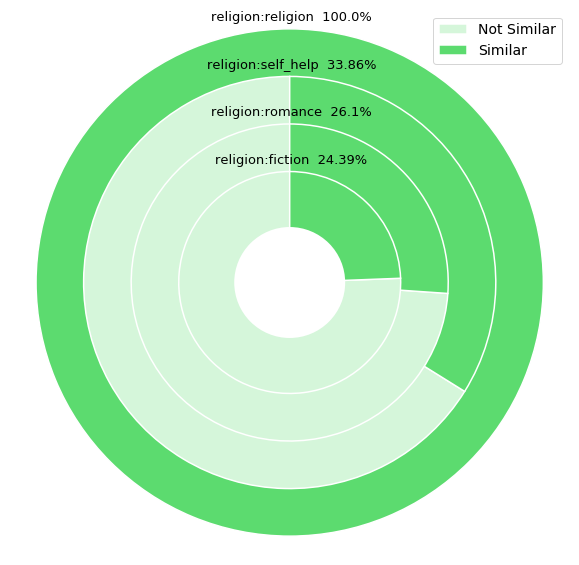

None


In [44]:
print(jaccard_plot(jaccard_df))

---

**Hope to hear your ideas on this. Happy Coding!!!**